In [ ]:
# ########################################################################################################
# This notebook is a proof of concept for pneumonia detection in chest x-ray images. It can work with all kinds 
# of x-ray images but for its best performance, the images must be cropped for chest regions only. This notebook
# expects the images to be stored in a main folder which have three more folders, 'train', 'val' and 'test'. Each
# of these three folders must have two sub-folders, one for each class ("NORMAL" and "PNEUMONIA" in this case).
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Add, multiply 
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

seed = 232
np.random.seed(seed)


In [ ]:
input_path = '/home/wabbas/shared/datasets/covid19/chest_xray/haar/'
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))


In [70]:
input_path = "/home/wabbas/shared/datasets/covid19/chest_xray/haar/"
def process_data(img_dims, batch_size):
    # Data generation objects
    if len(img_dims)>1:
        r = img_dims[0]; c = img_dims[1]
    else:
        r = img_dims, c = img_dims
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    print(r)
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(r, c), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(r, c), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (c,r))
            #print(img.shape)
            #img = detect_chest(img, detector)
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            lab = np.zeros([1,2])
            if cond=='/NORMAL/':
                lab[0,0] = 1
            elif cond=='/PNEUMONIA/':
                lab[0,1] = 1
            test_data.append(img)
            test_labels.append(lab)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
files = os.listdir(os.path.join(input_path,'test','NORMAL'))
img = plt.imread(os.path.join(input_path,'test','NORMAL',files[0]))
plt.imshow(img)

In [71]:
img_dims = [240,320]
epochs = 25
batch_size = 16

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)
test_data.shape

240
Found 5216 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


(531, 240, 320, 3)

In [ ]:
import keras
w = test_data.shape[2]; h = test_data.shape[1]
def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        return keras.layers.Concatenate(axis=3)([x1, x2])
def conv_block(inputs,num_filters,bn):
    x1 = SeparableConv2D(filters=num_filters, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    #x1 = SeparableConv2D(filters=num_filters, kernel_size=(5, 5), activation='relu', padding='same')(x1)
    #x1 = SeparableConv2D(filters=num_filters, kernel_size=(7, 7), activation='relu', padding='same')(x1)

    #x2 = SeparableConv2D(filters=num_filters, kernel_size=(3, 3), activation='relu', padding='same')(x1)
    x2 = SeparableConv2D(filters=4, kernel_size=(5, 5), activation='relu', padding='same')(inputs)

    #x3 = SeparableConv2D(filters=num_filters, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x3 = Conv2D(filters=num_filters, kernel_size=(1,1), activation='relu', padding='same')(x1)

    #x = crop_and_concat(x1,x2)
    x = crop_and_concat(x2,x3)
    x = Conv2D(filters=num_filters, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x1r = Conv2D(filters=num_filters, kernel_size=(1,1), activation='relu', padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(inputs)
    x = Add()([x,x1r])
    
    if bn:
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, trainable=True) (x)
    #x = Activation(tf.nn.sigmoid)(x)
    x = AveragePooling2D(pool_size=(2,2))(x)
    return x


    
    
r = 240; c = 320   
inputs = Input(shape=(r,c, 3))

x = conv_block(inputs,8,0)
x = conv_block(x,16,1)
x = conv_block(x,32,1)
x = conv_block(x,16,1)
x = conv_block(x,8,1)





# FC layer
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=32, activation='relu')(x)
#x = Dropout(rate=0.5)(x)



# Output layer
output = Dense(units=2, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
adamc = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= adamc, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
model.summary()

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


In [ ]:
history= hist
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

accuracy: 91.53 %
precision: 87.28 %
recall: 81.62 %
f1: 84.36 %
false negative rate: 1.04 %
false positive rate: 12.72 %


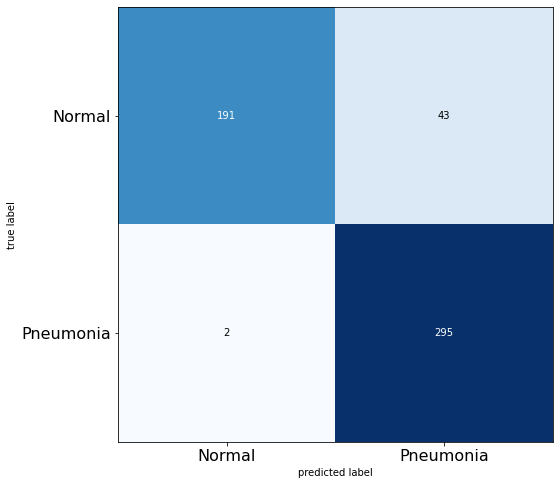

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
np.set_printoptions(precision = 4)
preds1 = model.predict(test_data)
preds = np.argmax(preds1,axis=1)
#test_labels = np.reshape(test_labels,[test_labels.shape[0],test_labels.shape[2]])
test_lab = test_labels[:,0,1]
accuracy = round(accuracy_score(test_lab, preds)*100,2)

conf_mat = confusion_matrix(test_lab, preds)
tn, fp, fn,tp = conf_mat.ravel()
pre = round(100*(tp/(tp+fp)),2)
rec = round(100*(tn/(tn+fp)),2)
f1 = round(2*pre*recall/(pre+rec),2)
fn_rate = round(100*fn/(fn+tn),2)
fp_rate = round(100*fp/(fp+tp),2)

print('accuracy: '+str(accuracy)+' %')
print('precision: '+str(pre)+' %')
print('recall: '+str(rec)+' %')
print('f1: '+str(f1)+' %')
print('false negative rate: '+str(fn_rate)+' %')
print('false positive rate: '+str(fp_rate)+' %')
plot_confusion_matrix(conf_mat,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
model.save('xray-pneumona-skip-convolution.h5')